In [16]:
import os, sys
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats

sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir
from utils.visualizations import histogram, plot, show_image_rows, bar_graph

In [2]:
RESULTS_DIR = os.path.join('saved', 'ADE20K', 'survey_results', 'ADE20K_soft_labels')
MEASUREMENT_COLUMN_NAMES = ['selectedAttrs', 'attrUncs']
TASK_METADATA_COLUMN_NAMES = ['filename', 'task', 'concept_group']
EXPLAINER_DIRNAME = 'saved/PlacesCategoryClassification/0510_102912/ADE20K_predictions/saga/KD_baseline_explainer/hparam_search/0523_164052/best'

CONGRUENCY_PATH_TEMPLATE = os.path.join(EXPLAINER_DIRNAME, '{}_paths.txt')
CONGRUENT_PATHS_PATH = CONGRUENCY_PATH_TEMPLATE.format('congruent')
INCONGRUENT_PATHS_PATH = CONGRUENCY_PATH_TEMPLATE.format('incongruent')

MODEL_DIRNAME = 'saved/PlacesCategoryClassification/0510_102912/ADE20K_predictions/saga'
# Path to where images in ADE20K are stored. (Prefix to path in congruent/incongruent paths files)
ADE20K_PARENT_DIR = os.path.join('data', 'broden1_224', 'images')
CSV_SAVE_PATH = os.path.join(os.path.dirname(RESULTS_DIR), 'processed_results_{}_samples.csv')



### Obtain list of CSV paths in `RESULTS_DIR`, load congruent and incongruent paths

In [3]:
csv_paths = []

for filename in os.listdir(RESULTS_DIR):
    if filename.endswith('csv'):
        csv_paths.append(os.path.join(RESULTS_DIR, filename))

csv_paths = sorted(csv_paths)
# Load congruent/incongruent paths
congruent_paths = set(read_lists(CONGRUENT_PATHS_PATH))
incongruent_paths = set(read_lists(INCONGRUENT_PATHS_PATH))


### Clean the dataframes and merge to 1 dataframe

In [4]:
df_list = []
for csv_path in csv_paths:
    print("Processing {}".format(os.path.basename(csv_path))) 
    df = pd.read_csv(csv_path)
    # Separate dataframe into rows with measurements and with metadata
    measurement_df = df[MEASUREMENT_COLUMN_NAMES]
    metadata_df = df.drop(MEASUREMENT_COLUMN_NAMES, axis=1)

    # Drop empty rows
    measurement_df = measurement_df.dropna()
    # Drop rows without data in task metadata columns
    metadata_df = metadata_df.dropna(subset=TASK_METADATA_COLUMN_NAMES)

    # Remove columns that are empty
    metadata_df = metadata_df.dropna(axis=1)
    
    # for each image, add a column for whether it is a congruent or incongruent example
    congruents = []
    for filename in metadata_df['filename']:
        path = os.path.join(ADE20K_PARENT_DIR, filename)
        if path in congruent_paths:
            congruents.append(1)
        elif path in incongruent_paths:
            congruents.append(0)
        else:
            raise ValueError("Path {} not found in congruent or incongruent paths... :0".format(path))
    metadata_df['congruent'] = congruents

    # Assert that the two DFs have the same number of rows
    assert len(metadata_df) == len(measurement_df), "Uneven length data frames. Metadata length: {} Measurement length: {}".format(
        len(metadata_df), len(measurement_df))

    # Reset indices to allow for joining appropriately
    metadata_df = metadata_df.reset_index(drop=True)
    measurement_df = measurement_df.reset_index(drop=True)


    # Join the data frames
    df = pd.concat([metadata_df, measurement_df], axis=1)
    assert len(df) == len(metadata_df)

    # Add dataframe to list of dataframes
    df_list.append(df)
    
# Concatenate rows of all dataframes together
df = pd.concat(df_list)

n_congruent = len(df[df['congruent'] == 1])
n_incongruent = len(df[df['congruent'] == 0])
print("Total of {} congruent samples and {} incongruent samples".format(n_congruent, n_incongruent))


Processing 000_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h26.47.486.csv
Processing 001_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h35.07.423.csv
Processing 002_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h40.48.508.csv
Processing 003_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h48.15.198.csv
Processing 004_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h55.01.103.csv
Processing 005_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h00.12.78.csv
Processing 006_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h05.33.934.csv
Processing 007_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h11.11.320.csv
Processing 008_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-04_09h23.31.131.csv
Processing 009_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-04_09h28.52.510.csv
Total of 190 congruent samples and 110 incongruent samples


In [5]:
save_path = CSV_SAVE_PATH.format(len(df))

if os.path.exists(save_path):
    print("Path {} already exists".format(save_path))
else:
    df.to_csv(save_path)
    print("Saving results to {}".format(save_path))

Path saved/ADE20K/survey_results/processed_results_300_samples.csv already exists


### Process each uncertainty attribute vector to soft_labels, compute 1) entropy and 2) confusion

In [6]:
SCENE_CATEGORIES_PATH = os.path.join('data', 'ade20k', 'scene_categories.txt')
n_samples = 300

csv_path = CSV_SAVE_PATH.format(n_samples)

# Create a 2-way dictionary mapping from category <-> index
scene_categories = read_lists(SCENE_CATEGORIES_PATH)
scene_categories_dict = {}
for idx, category in enumerate(scene_categories):
    scene_categories_dict[idx] = category
    scene_categories_dict[category] = idx
n_categories = len(scene_categories)

# Load CSV
df = pd.read_csv(csv_path)

In [7]:
def get_top_2_confusion(soft_labels):
    '''
    Given soft label distribution, calculate difference between top 2 labels

    Arg(s):
        soft_labels : N x C np.array
            soft label array for N samples and C class predictions

    Returns:
        confusion : N-dim np.array
            confusion for each sample
    '''
    # Sort soft labels ascending
    sorted_soft_labels = np.sort(soft_labels, axis=-1)
    # Calculate difference of p(x) for top 2 classes
    top_2_difference = sorted_soft_labels[:, -1] - sorted_soft_labels[:, -2]
    # Confusion = 1 - difference (higher is worse)
    top_2_confusion = 1 - top_2_difference

    return top_2_confusion


#### Calculate soft labels, and predictions

In [8]:
# if 'human_probabilities' not in df.columns:
print("Calculating soft labels")
human_soft_labels = []
unnormalized_human_soft_labels = []
human_predictions = []
for row in tqdm(df['attrUncs']):
    soft_label = np.zeros(n_categories)
    # Each 'score' item is a dictionary of class and certainty amount
    row = json.loads(row)
    for item in row:
        category = item['label']
        certainty = item['y'] / 100.0
        category_idx = scene_categories_dict[category]
        soft_label[category_idx] = certainty
    label_sum = np.sum(soft_label)
    unnormalized_human_soft_labels.append(soft_label)
    # Distribute remaining mass across other classes
    # if label_sum < 1.0:
    #     remaining = 1.0 - label_sum
    #     n_classes_left = n_categories - np.count_nonzero(soft_label)
    #     remaining_per_class = remaining / n_classes_left
    #     soft_label = np.where(soft_label == 0, remaining_per_class, soft_label)    
    # # Normalize to sum to 1
    # elif label_sum > 1.0:
        # soft_label = soft_label / label_sum

    # Normalize to sum to one
    soft_label = soft_label / label_sum
    # Assert the soft label sums to 1
    assert np.abs(np.sum(soft_label) - 1.0) < 1e-5

    human_soft_labels.append(soft_label)
    human_predictions.append(np.argmax(soft_label))

df['human_probabilities'] = human_soft_labels
df['human_outputs'] = unnormalized_human_soft_labels
df['human_predictions'] = human_predictions
print("Calculated soft labels")
# else:
    # print("Soft labels already in dataframe")



Calculating soft labels


100%|██████████████████████████████████████| 300/300 [00:00<00:00, 17556.74it/s]

Calculated soft labels


### Add the model's and explainer's soft labels to the dataframe

In [9]:
# Obtain explainer softmax probabilities
explainer_outputs_path = os.path.join(EXPLAINER_DIRNAME, 'val_outputs_predictions.pth')
explainer_out = torch.load(explainer_outputs_path)
explainer_probabilities = explainer_out['probabilities']

# Obtainer model's softmax probabilities
model_outputs_path = os.path.join(MODEL_DIRNAME, 'val_outputs_predictions.pth')
model_out = torch.load(model_outputs_path)
model_probabilities = model_out['probabilities']

# Obtain mapping from image name to index of validation set
image_labels_path = 'data/ade20k/full_ade20k_imagelabels.pth'
image_labels = torch.load(image_labels_path)
val_images = image_labels['val']
val_images = [path.split('images/')[-1] for path in val_images]
val_name_idx_dict = {}
for idx, image_name in enumerate(val_images):
    val_name_idx_dict[image_name] = idx


# For each row in the data frame, store the explainers' and models' outputs
for name, outputs in zip(['explainer', 'model'], [explainer_out, model_out]):
    for output_type in ['outputs', 'probabilities', 'predictions']:
        cur_outputs = outputs[output_type]
        accumulator = []
        for image_name in df['filename']:
            val_idx = val_name_idx_dict[image_name]
            cur_item = cur_outputs[val_idx]
            accumulator.append(cur_item)
        df['{}_{}'.format(name, output_type)] = accumulator
print("Added model and explainer's outputs, probabilities, and predictions to dataframe")

Added model and explainer's outputs, probabilities, and predictions to dataframe


### Calculate entropy and KL divergence

In [10]:
# Calculate entropy
entropy = stats.entropy(human_soft_labels, axis=1)
df['entropy'] = entropy

# Top 2 confusion
unnormalized_top_2_confusion = get_top_2_confusion(unnormalized_human_soft_labels)
df['unnormalized_top_2_confusion'] = unnormalized_top_2_confusion

# KL divergence between model-explainer
p = np.stack(df['explainer_probabilities'], axis=0)
q = np.stack(df['model_probabilities'], axis=0)
kl_model_explainer = stats.entropy(pk=p, qk=q, axis=1)
df['kl_model_explainer'] = kl_model_explainer

### Save Results, overwriting DF

In [11]:
# Create a dictionary
human_soft_labels_arr = np.stack(human_soft_labels, axis=0)
print(human_soft_labels_arr.shape)
data = {
    "filename": df['filename'],
    "congruent": df['congruent'],
    "soft_label": human_soft_labels_arr,
    "entropy": entropy,
    "unnormalized_top_2_confusion": unnormalized_top_2_confusion
}
df.to_csv(csv_path)
print("Saved csv with soft labels to {}".format(csv_path))
pth_path = csv_path.replace('csv', 'pth')
torch.save(data, pth_path)
print("Saved dictionary with filenames, congruency, and soft labels to {}".format(pth_path))
    


(300, 16)
Saved csv with soft labels to saved/ADE20K/survey_results/processed_results_300_samples.csv
Saved dictionary with filenames, congruency, and soft labels to saved/ADE20K/survey_results/processed_results_300_samples.pth


### Examine Results

### 5 way separation by these categories
1. Model = Explainer = Human
2. Model = Explainer != Human
3. Model = Human != Explainer
4. Explainer = Human ! = Model
5. Model != Explainer != Human

In [56]:
dfs = []
# Case 1: model = explainer = human 
df1 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] == df['human_predictions'])]
dfs.append(df1)
# Case 2: model = explainer != human
df2 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
dfs.append(df2)

# Case 3: model = human != explainer
df3 = df[(df['model_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
dfs.append(df3)

# Case 4: explainer = human != model
df4 = df[(df['explainer_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
dfs.append(df4)

# Case 5: explainer != model != human
df5 = df[(df['explainer_predictions'] != df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
dfs.append(df5)

# Check that no rows overlap, all mutually exclusive
for i in range(len(dfs) - 1):
    for j in range(i+1, len(dfs)):
        overlap = set(dfs[i]['filename']) & set(dfs[j]['filename'])
        assert len(overlap) == 0
        
groups_save_dir = os.path.join(os.path.dirname(csv_path), 'group_csvs')
ensure_dir(groups_save_dir)

for idx, cur_df in enumerate(dfs):
    print("Case {} has {} rows".format(idx+1, len(cur_df)))
    mean_entropy = cur_df['entropy'].mean()
    std_entropy = cur_df['entropy'].std()
    
    mean_t2c = cur_df['unnormalized_top_2_confusion'].mean()
    std_t2c = cur_df['unnormalized_top_2_confusion'].std()
    print("\tEntropy: {:.3f} ({:.3f})".format(mean_entropy, std_entropy))
    print("\tT2C: {:.3f} ({:.3f})".format(mean_t2c, std_t2c))
    cur_csv_save_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(idx+1))
    cur_df.to_csv(cur_csv_save_path)
    print("Saved CSV for group {} to {}".format(idx+1, cur_csv_save_path))
    

Case 1 has 132 rows
	Entropy: 0.201 (0.289)
	T2C: 0.193 (0.252)
Saved CSV for group 1 to saved/ADE20K/survey_results/group_csvs/group_1.csv
Case 2 has 58 rows
	Entropy: 0.560 (0.350)
	T2C: 0.516 (0.281)
Saved CSV for group 2 to saved/ADE20K/survey_results/group_csvs/group_2.csv
Case 3 has 62 rows
	Entropy: 0.315 (0.309)
	T2C: 0.335 (0.285)
Saved CSV for group 3 to saved/ADE20K/survey_results/group_csvs/group_3.csv
Case 4 has 13 rows
	Entropy: 0.272 (0.313)
	T2C: 0.312 (0.252)
Saved CSV for group 4 to saved/ADE20K/survey_results/group_csvs/group_4.csv
Case 5 has 35 rows
	Entropy: 0.616 (0.405)
	T2C: 0.544 (0.291)
Saved CSV for group 5 to saved/ADE20K/survey_results/group_csvs/group_5.csv


#### Calculate statistical significance of entropy and T2C between Case 1 and all 4 other cases

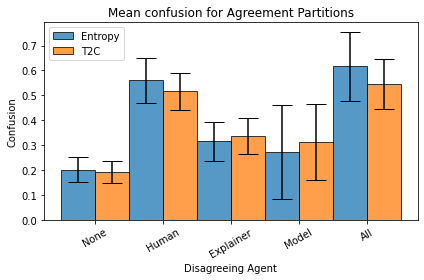

In [51]:
graph_data = {}
for metric in ['entropy', 'unnormalized_top_2_confusion']:
    means = []
    stds = []
    sems = []
    pvalues = []
    tstats = []
    cis = []
    for idx in range(5):
        cur_df = dfs[idx]
        means.append(cur_df[metric].mean())
        stds.append(cur_df[metric].std())
        sems.append(stats.sem(cur_df[metric]))
        
        if idx > 0:
            base = dfs[0][metric]
            comparison = cur_df[metric]
            
            ttest = stats.ttest_ind(
                base,
                comparison,
                equal_var=False,
                alternative='less'
            )
            pvalues.append(ttest.pvalue)
            tstats.append(ttest.statistic)
        else:
            pvalues.append(-1)
            tstats.append(None)
        # print("mean: {} sd: {} sem: {} tstat: {} pvalue: {}".format(
        #     means[-1],
        #     stds[-1],
        #     sems[-1],
        #     tstats[-1],
        #     pvalues[-1]))
        confidence_interval = stats.norm.interval(
            confidence=0.95,
            # df=len(cur_df)-1,
            loc=cur_df[metric].mean(),
            scale=stats.sem(cur_df[metric]))
        tconfidence_interval = stats.t.interval(
            confidence=0.95,
            df=len(cur_df)-1,
            loc=cur_df[metric].mean(),
            scale=stats.sem(cur_df[metric]))
        cis.append((tconfidence_interval[1] - tconfidence_interval[0]) / 2)

            
    graph_data[metric] = {
        'means': np.array(means),
        'stds': np.array(stds),
        'sems': np.array(sems),
        'pvalues': np.array(pvalues),
        'cis': np.array(cis)
    }
    

bar_graph_save_path = os.path.join(
    'saved/ADE20K/survey_results/graphs', 'confusion_across_groups.png')
bar_graph(
    data=np.stack([graph_data['entropy']['means'], graph_data['unnormalized_top_2_confusion']['means']], axis=0),
    errors=np.stack([graph_data['entropy']['cis'], graph_data['unnormalized_top_2_confusion']['cis']], axis=0),
    labels=['None', 'Human', 'Explainer', 'Model', 'All'],
    groups=['Entropy', 'T2C'],
    xlabel='Disagreeing Agent',
    ylabel='Confusion',
    xlabel_rotation=30,
    title='Mean confusion for Agreement Partitions',
    save_path=bar_graph_save_path
)


In [55]:
# Perform t-test on cases 2 and 5
for metric in ['entropy', 'unnormalized_top_2_confusion']:
    ttest = stats.ttest_ind(
        dfs[1][metric],
        dfs[4][metric],
        equal_var=True,
        alternative='two-sided'
    )
    print(ttest)

Ttest_indResult(statistic=-0.709657269706876, pvalue=0.47973114773802905)
Ttest_indResult(statistic=-0.4619386236447016, pvalue=0.6452277995272067)


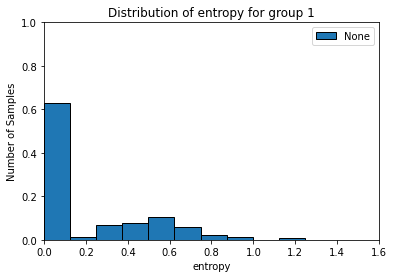

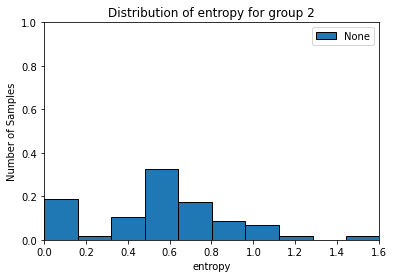

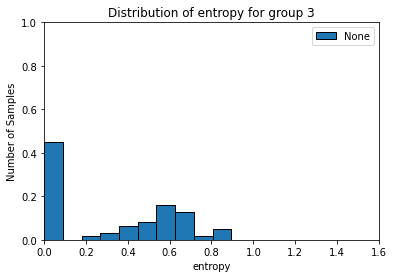

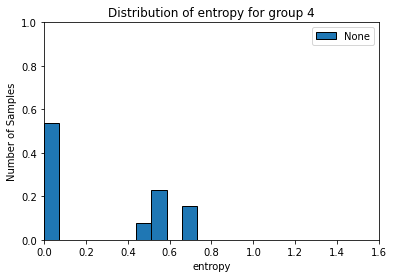

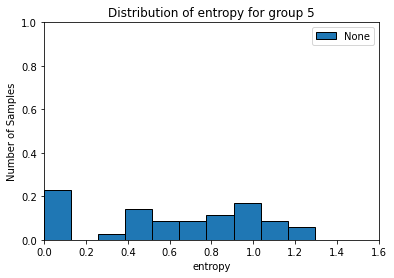

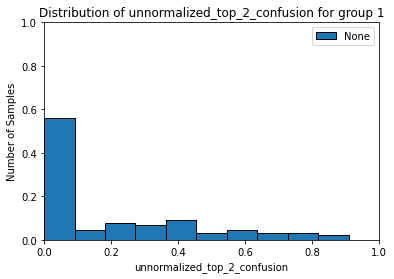

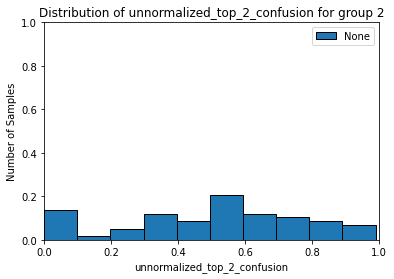

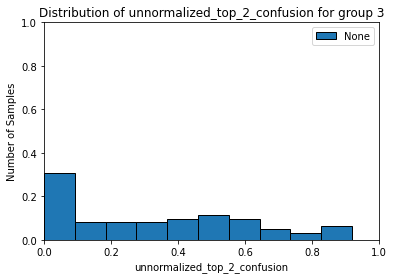

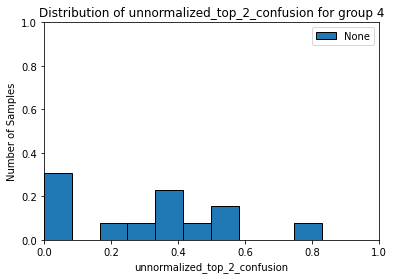

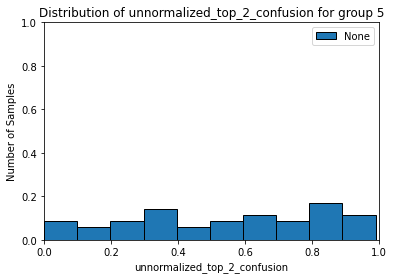

<Figure size 432x288 with 0 Axes>

In [21]:
# Create histograms for all groups to show distribution of confusion
graph_save_dir = os.path.join(os.path.dirname(csv_path), 'graphs')
ensure_dir(graph_save_dir)
for confusion_metric in ['entropy', 'unnormalized_top_2_confusion']:
    for idx, cur_df in enumerate(dfs):
        data = [cur_df[confusion_metric].to_numpy()]
        graph_save_path = os.path.join(graph_save_dir, '{}_group{}.png'.format(
            confusion_metric, idx+1))
        
        histogram(
            data=data,
            weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
            title="Distribution of {} for group {}".format(confusion_metric, idx+1),
            xlabel=confusion_metric,
            ylabel="Number of Samples",
            xlim=(0, 1.6) if confusion_metric == 'entropy' else (0, 1.0),
            ylim=(0, 1),
            show=True,
            save_path=graph_save_path
        )
        

In [23]:
# Are groups 3,4 statistically significant from one another?
for metric in ['entropy', 'unnormalized_top_2_confusion']:
    group_3 = dfs[2][metric]
    group_4 = dfs[3][metric]
    ttest = stats.ttest_ind(
        group_3,
        group_4,
        equal_var=False
    )
    print("P value for {}: {}".format(metric, ttest.pvalue))

P value for entropy: 0.6580993869628459
P value for unnormalized_top_2_confusion: 0.7796251362210062


#### How many of wrong predictions (of model or explainer) are the second human choice?

In [84]:
# For case 2, what is the mean rank of the model (and explainer's predictions) of the humans
idx = 1
def rank_odd_one_out(cur_df, ooo_name):
    # cur_df = dfs[idx]
    n_samples = len(cur_df)
    human_probabilities = np.stack(cur_df['human_probabilities'].to_numpy(), axis=0)
    human_predictions = np.argmax(human_probabilities, axis=1)
    model_predictions = cur_df['model_predictions'].to_numpy()
    explainer_predictions = cur_df['explainer_predictions'].to_numpy()
    # Sanity check
    if ooo_name == 'both':
        # assert (model_predictions == explainer_predictions).all()
        assert not (model_predictions == human_predictions).any()
        assert not (explainer_predictions == human_predictions).any()
        ooo_predictions = model_predictions
    elif ooo_name == 'model':
        # assert (explainer_predictions == human_predictions).all()
        assert not (model_predictions == human_predictions).any()
        ooo_predictions = model_predictions
    elif ooo_name == 'explainer':
        # assert (model_predictions == human_predictions).all()
        assert not (explainer_predictions == human_predictions).any()
        ooo_predictions = explainer_predictions
    else:
        raise ValueError("{} not supported".format(ooo_name))
    sort_idxs = np.argsort(-human_probabilities, axis=1)
    # Count number of rows where only non-zero in human annotations is the top prediction
    mask = np.where(human_probabilities > 0, 1, 0)
    ctr = np.sum(mask, axis=1)
    ranks = []
    for idx in range(n_samples):
        cur_ctr = ctr[idx]
        cur_argsort = sort_idxs[idx]
        cur_prediction = ooo_predictions[idx]
        prediction_rank = np.where(cur_argsort == cur_prediction)[0][0]
        # This means it is one of the 0's in the human probability distribution
        if prediction_rank >= cur_ctr:
            ranks.append(-1)
            # print("soft label: {}".format(human_probabilities[idx]))
            # print("model prediction: {} rank {}".format(cur_prediction, prediction_rank))
            # print("cur ctr: {}".format(cur_ctr))
        else:
            ranks.append(prediction_rank)
    ranks = pd.Series(ranks)
    n_out_of_rank = len(ranks[ranks == -1])
    n_top_2 = len(ranks[ranks == 1])
    n_else = len(ranks[ranks > 1])
    return {
        "n_out_of_rank": n_out_of_rank,
        "n_top_2": n_top_2,
        "n_else": n_else,
        "n_samples": n_samples
    }



In [85]:
ooo_names = ['none', 'both', 'explainer', 'model', 'all']
# Examining cases 2-4
for idx in range(1, 4):
    print("Case {}: {} is misaligned".format(idx+1, ooo_names[idx]))
    rank_counts = rank_odd_one_out(
        cur_df=dfs[idx],
        ooo_name=ooo_names[idx])
    n_out_of_rank = rank_counts['n_out_of_rank']
    n_top_2 = rank_counts['n_top_2']
    n_else = rank_counts['n_else']
    n_samples = rank_counts['n_samples']
    print("{}/{} {:.3f} samples the model and explainer predict something the humans are sure it is not".format(n_out_of_rank, n_samples, n_out_of_rank / n_samples))
    print("{}/{} {:.3f} samples have model prediction as 2nd top prediction".format(n_top_2, n_samples, n_top_2 / n_samples))
    print("{}/{} {:.3f} samples where model prediction is beyond top 2 but plausible".format(n_else, n_samples, n_else / n_samples))

Case 2: both is misaligned
26/58 0.448 samples the model and explainer predict something the humans are sure it is not
27/58 0.466 samples have model prediction as 2nd top prediction
5/58 0.086 samples where model prediction is beyond top 2 but plausible
Case 3: explainer is misaligned
45/62 0.726 samples the model and explainer predict something the humans are sure it is not
16/62 0.258 samples have model prediction as 2nd top prediction
1/62 0.016 samples where model prediction is beyond top 2 but plausible
Case 4: model is misaligned
9/13 0.692 samples the model and explainer predict something the humans are sure it is not
4/13 0.308 samples have model prediction as 2nd top prediction
0/13 0.000 samples where model prediction is beyond top 2 but plausible


In [87]:
# Examine case 5: how does the disagreeance of the explainer and humans differ from model and humans?
cur_df = dfs[4]
explainer_rank_counts = rank_odd_one_out(
    cur_df=cur_df,
    ooo_name='explainer')
model_rank_counts = rank_odd_one_out(
    cur_df=cur_df,
    ooo_name='model')

for name, rank_counts in zip(['explainer', 'model'], [explainer_rank_counts, model_rank_counts]):
    print("{} prediction rankings:".format(name))
    n_out_of_rank = rank_counts['n_out_of_rank']
    n_top_2 = rank_counts['n_top_2']
    n_else = rank_counts['n_else']
    n_samples = rank_counts['n_samples']
    print("{}/{} {:.3f} samples the model and explainer predict something the humans are sure it is not".format(n_out_of_rank, n_samples, n_out_of_rank / n_samples))
    print("{}/{} {:.3f} samples have model prediction as 2nd top prediction".format(n_top_2, n_samples, n_top_2 / n_samples))
    print("{}/{} {:.3f} samples where model prediction is beyond top 2 but plausible".format(n_else, n_samples, n_else / n_samples))
    
cur_df.to_csv(os.path.join('saved', 'ADE20K', 'survey_results', 'case_5.csv'))

explainer prediction rankings:
23/35 0.657 samples the model and explainer predict something the humans are sure it is not
11/35 0.314 samples have model prediction as 2nd top prediction
1/35 0.029 samples where model prediction is beyond top 2 but plausible
model prediction rankings:
24/35 0.686 samples the model and explainer predict something the humans are sure it is not
6/35 0.171 samples have model prediction as 2nd top prediction
5/35 0.143 samples where model prediction is beyond top 2 but plausible


#### Calculate entropy between congruent and incongruent samples and graph histograms

In [47]:
csv_path = os.path.join('saved', 'ADE20K', 'survey_results', 'processed_results_300_samples.csv')

df = pd.read_csv(csv_path)


In [48]:
congruent_df = df[df['congruent'] == 1]
incongruent_df = df[df['congruent'] == 0]
# assert len(congruent_df) == len(incongruent_df)
assert len(congruent_df) + len(incongruent_df) == len(df)

confusion_metrics = [
    'entropy', 
    'unnormalized_top_2_confusion',
    'kl_model_explainer'
]


In [49]:
# Calculate statistical significance 
for confusion_metric in confusion_metrics:
    congruent_values = congruent_df[confusion_metric].to_numpy()
    incongruent_values = incongruent_df[confusion_metric].to_numpy()
    mean_congruent_value = congruent_values.mean()
    std_congruent_value = congruent_values.std()
    mean_incongruent_value = incongruent_values.mean()
    std_incongruent_value = incongruent_values.std()
    
    print("{} congruent: {:.3f} ({:.3f})".format(confusion_metric, mean_congruent_value, std_congruent_value))
    print("{} incongruent: {:.3f} ({:.3f})".format(confusion_metric, mean_incongruent_value, std_incongruent_value))

    ttest = stats.ttest_ind(
        congruent_values,
        incongruent_values,
        equal_var=False
    )
    print("T-test for {} without equal variance: {} (p={})".format(confusion_metric, ttest.statistic, ttest.pvalue))

    ttest = stats.ttest_ind(
        congruent_values,
        incongruent_values,
        equal_var=True
    )
    print("T-test for {} with equal variance: {} (p={})".format(confusion_metric, ttest.statistic, ttest.pvalue))

entropy congruent: 0.310 (0.349)
entropy incongruent: 0.406 (0.368)
T-test for entropy without equal variance: -2.204395315968427 (p=0.02854375495713777)
T-test for entropy with equal variance: -2.236703312313414 (p=0.026045343876554165)
unnormalized_top_2_confusion congruent: 0.291 (0.299)
unnormalized_top_2_confusion incongruent: 0.399 (0.297)
T-test for unnormalized_top_2_confusion without equal variance: -2.9950083239592042 (p=0.003045958543890796)
T-test for unnormalized_top_2_confusion with equal variance: -2.989480379848614 (p=0.0030274053003198913)
kl_model_explainer congruent: 0.436 (0.496)
kl_model_explainer incongruent: 0.929 (0.670)
T-test for kl_model_explainer without equal variance: -6.6904260741380615 (p=2.771166189862776e-10)
T-test for kl_model_explainer with equal variance: -7.23958525716645 (p=3.8476811058620326e-12)


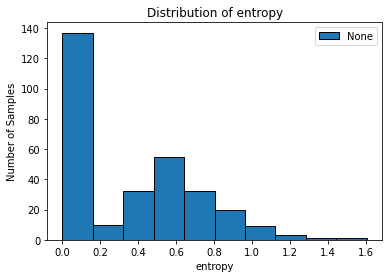

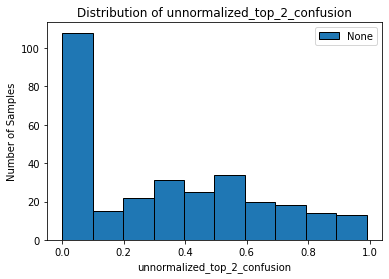

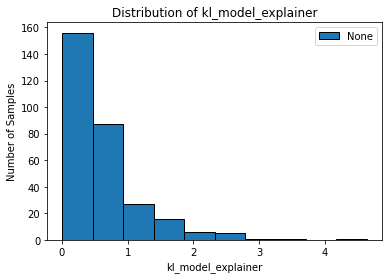

<Figure size 432x288 with 0 Axes>

In [50]:
# Histogram of all entropy values
for confusion_metric in confusion_metrics:
    histogram(
        data=[df[confusion_metric].to_numpy()],
        title="Distribution of {}".format(confusion_metric),
        xlabel=confusion_metric,
        ylabel="Number of Samples",
        show=True
    )

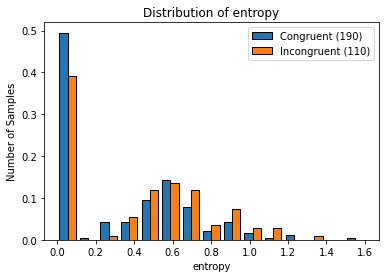

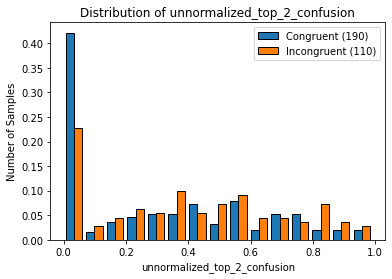

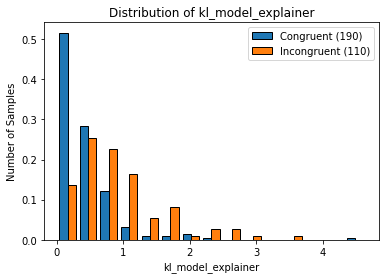

<Figure size 432x288 with 0 Axes>

In [51]:
# Separate plots for congruent vs incongruent
for confusion_metric in confusion_metrics:
    data = [congruent_df[confusion_metric].to_numpy(), incongruent_df[confusion_metric].to_numpy()]
    histogram(
        data=data,
        # weights=None,
        weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
        labels=["Congruent ({})".format(len(congruent_df)), "Incongruent ({})".format(len(incongruent_df))],
        n_bins=15,
        title="Distribution of {}".format(confusion_metric),
        xlabel=confusion_metric,
        ylabel="Number of Samples",
        show=True
    )


Entropy and KL Pearsons correlation: 0.113 (p=0.050)


<Figure size 432x288 with 0 Axes>

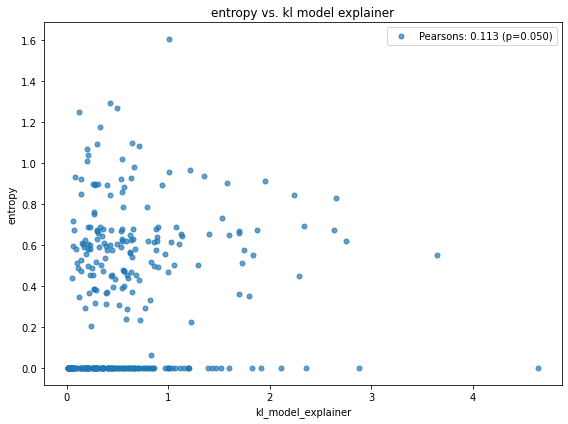

T2C and KL Pearsons correlation: 0.147 (p=0.011)


<Figure size 432x288 with 0 Axes>

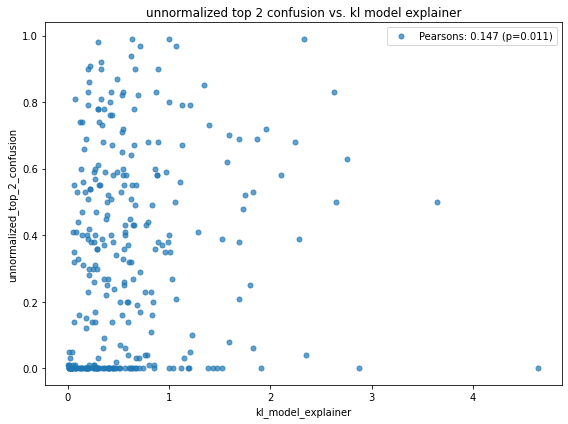

(<Figure size 576x432 with 1 Axes>,
 <Axes: title={'center': 'unnormalized top 2 confusion vs. kl model explainer'}, xlabel='kl_model_explainer', ylabel='unnormalized_top_2_confusion'>)

In [60]:
# Plot entropy vs top-2 confusion and color code by congruent or not
ylabel = 'entropy'
xlabel = 'kl_model_explainer'

entropy_pearsons = stats.pearsonr(df[xlabel], df[ylabel])
print("Entropy and KL Pearsons correlation: {:.3f} (p={:.3f})".format(
    entropy_pearsons.statistic,
    entropy_pearsons.pvalue))
plot(
    xs=[df[xlabel]],
    ys=[df[ylabel]],
    # labels=['Congruent', 'Incongruent'],
    labels=['Pearsons: {:.3f} (p={:.3f})'.format(entropy_pearsons.statistic, entropy_pearsons.pvalue)],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    show=True
)

ylabel = 'unnormalized_top_2_confusion'
t2c_pearsons = stats.pearsonr(df[xlabel], df[ylabel])
print("T2C and KL Pearsons correlation: {:.3f} (p={:.3f})".format(
    t2c_pearsons.statistic,
    t2c_pearsons.pvalue))
plot(
    xs=[df[xlabel]],
    ys=[df[ylabel]],
    # labels=['Congruent', 'Incongruent'],
    labels=['Pearsons: {:.3f} (p={:.3f})'.format(t2c_pearsons.statistic, t2c_pearsons.pvalue)],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    show=True
)

(<Figure size 576x432 with 1 Axes>,
 <Axes: title={'center': 'entropy vs. top 2 confusion'}, xlabel='top_2_confusion', ylabel='entropy'>)

<Figure size 432x288 with 0 Axes>

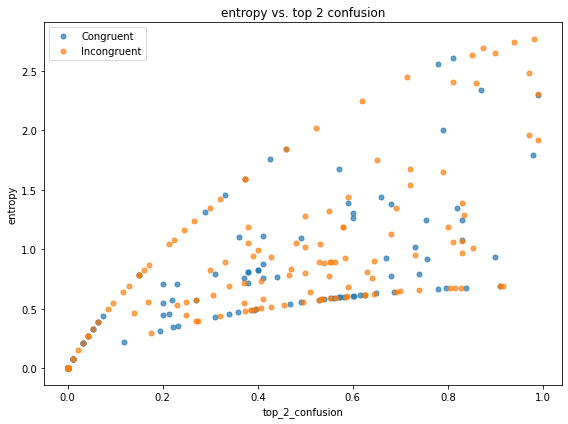

In [162]:
# Plot entropy vs top-2 confusion and color code by congruent or not
ylabel = 'entropy'
xlabel = 'top_2_confusion'

plot(
    xs=[congruent_df[xlabel], incongruent_df[xlabel]],
    ys=[congruent_df[ylabel], incongruent_df[ylabel]],
    labels=['Congruent', 'Incongruent'],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6)
)

<Figure size 432x288 with 0 Axes>

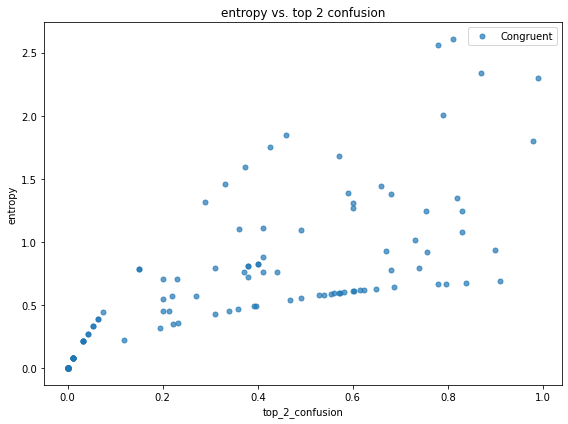

<Figure size 432x288 with 0 Axes>

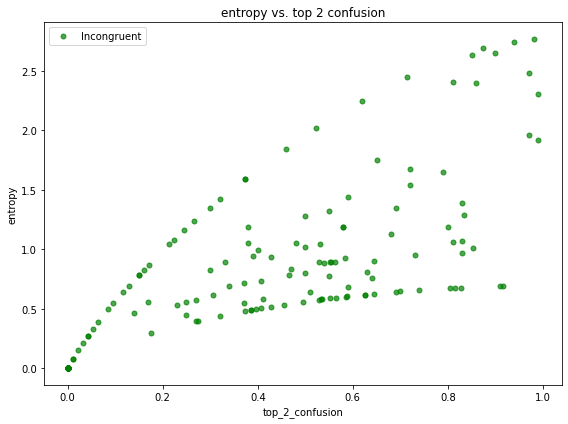

150 150


In [170]:
# Plot entropy vs top-2 confusion and color code by congruent or not
ylabel = 'entropy'
xlabel = 'top_2_confusion'
plot(
    xs=[congruent_df[xlabel]],
    ys=[congruent_df[ylabel]],
    labels=['Congruent'],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    show=True
)

plot(
    xs=[incongruent_df[xlabel]],
    ys=[incongruent_df[ylabel]],
    labels=['Incongruent'],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    colors=['g'],
    show=True
)

print(len(congruent_df), len(incongruent_df))


#### Visualize Examples of High and Low confusion for both congruent and incongruent samples

[0.0, 0.0, 0.0, 0.0, 0.0]


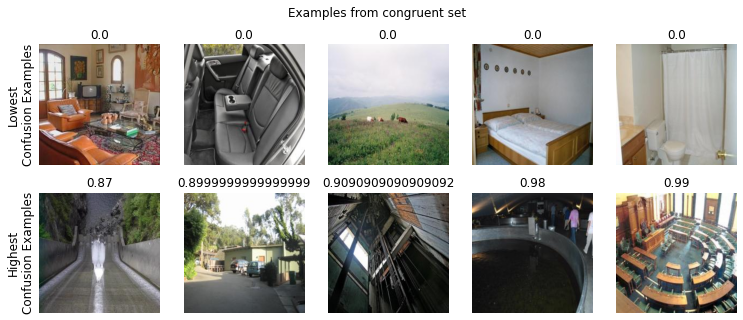

[0.0, 0.0, 0.0, 0.0, 0.0]


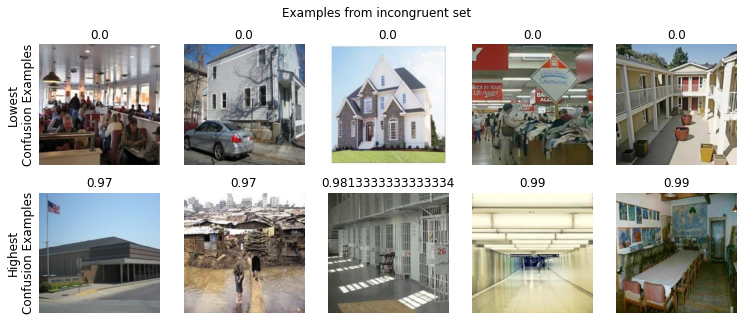

In [190]:
itrs = [
    ('congruent', congruent_df),
    ('incongruent', incongruent_df)
]
image_parent_dir = os.path.join('data', 'broden1_224', 'images')
confusion_metric = 'top_2_confusion'
n_display = 5
for congruency_str, df in itrs:
    sorted_df = df.sort_values(confusion_metric)

    lowest_df = sorted_df.iloc[:n_display]
    low_image_name = lowest_df['filename']
    low_image_paths = [os.path.join(image_parent_dir, image_name) for image_name in low_image_name]
    low_images = [load_image(path) for path in low_image_paths]
    low_confusions = list(lowest_df[confusion_metric])

    highest_df = sorted_df.iloc[-n_display:]
    high_image_name = highest_df['filename']
    high_image_paths = [os.path.join(image_parent_dir, image_name) for image_name in high_image_name]
    high_images = [load_image(path) for path in high_image_paths]
    high_confusions = list(highest_df[confusion_metric])
    print(low_confusions)
    show_image_rows(
        images=[low_images, high_images],
        image_titles=[low_confusions, high_confusions],
        row_labels=['Lowest\nConfusion Examples', 'Highest\nConfusion Examples'],
        figure_title='Examples from {} set'.format(congruency_str)
    )